In [22]:
from deepforest import main
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import rasterio
import csv
import fiona
import numpy as np
from skimage import measure

Reading config file: /home/udanny/anaconda3/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


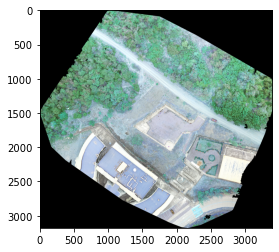

In [23]:
m = main.deepforest()
m.use_release()
imgpath = "Mosaicos/bosqueed.tif"
imagen = cv2.imread(imgpath)
image_copy = np.copy(imagen)
plt.imshow(imagen)

In [24]:
box = m.predict_image(path=imgpath, return_plot=False)
box.head()
#box.info

,xmin,ymin,xmax,ymax,label,score
0,47.0,1358.0,406.0,1769.0,Tree,0.142108
1,548.0,1158.0,769.0,1378.0,Tree,0.137820
2,2589.0,961.0,3268.0,1599.0,Tree,0.122976
3,1797.0,34.0,2288.0,482.0,Tree,0.120055
4,822.0,1068.0,1029.0,1275.0,Tree,0.119043


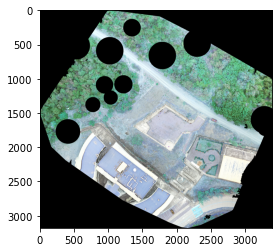

In [25]:
mask = 255*np.ones(imagen.shape,np.uint8)
def fun(row):
    x = int(row['xmin'])
    y = int(row['ymin'])
    X1 = int(row['xmax'])
    Y1 = int(row['ymax'])
    centro = (x+(X1-x),y+(Y1-y))
    radio = int(min((Y1-y)/2,(X1-x)/2,200))
    #cv2.circle(mask,centro,radio,(0,0,0),-1)
    cv2.circle(image_copy,centro,radio,(0,0,0),-1)
    #image_copy[y:Y1,x:X1] = 0
    mask[y:Y1,x:X1] = 0
box.apply(lambda r : fun(r), axis = 1)
plt.imshow(image_copy)

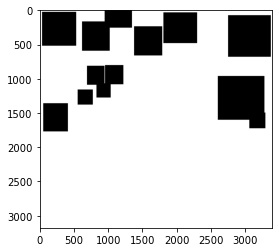

In [26]:
plt.imshow(mask)

Erosión imagen clasificada

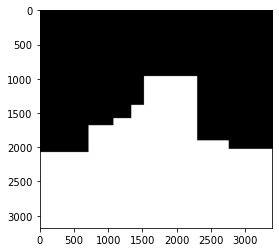

In [27]:
kernel = np.ones((7, 7), 'uint8')
erosion = cv2.erode(mask, kernel, iterations=100)
erosion = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations=100)
#erosion = cv2.dilate(mask, kernel,iterations=50)
plt.imshow(erosion)

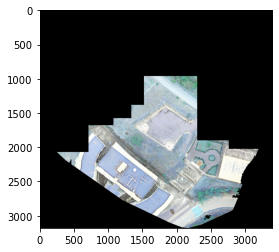

In [28]:
fg = cv2.bitwise_and(imagen, erosion)
plt.imshow(fg)

In [29]:
cv2.imwrite('forest.tif',fg)

True

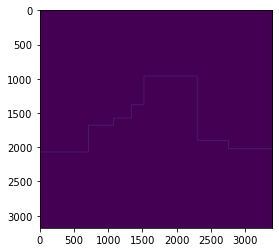

In [30]:
edged = cv2.Canny(erosion, 0, 0)
_, threshold = cv2.threshold(edged, 100, 255, cv2.THRESH_BINARY) 
contours, _= cv2.findContours(threshold, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
plt.imshow(edged)

In [31]:
dataset = rasterio.open(imgpath)

In [32]:
data = []
data.append ({"x": "x", "y": "y","name":"name"})
data.append ({"x": dataset.bounds.left, "y": dataset.bounds.top,"name":"Borde"})
data.append ({"x": dataset.bounds.left, "y": dataset.bounds.bottom,"name":"Borde"})
data.append ({"x": dataset.bounds.right, "y": dataset.bounds.bottom,"name":"Borde"})
data.append ({"x": dataset.bounds.right, "y": dataset.bounds.top,"name":"Borde"})
poligono = []
#poligono.append([[[dataset.bounds.left,dataset.bounds.top,0.0],[dataset.bounds.left,dataset.bounds.bottom,0.0],
#[dataset.bounds.right,dataset.bounds.bottom,0.0],[dataset.bounds.right,dataset.bounds.top,0.0]]])

for cnt in contours : 
    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 
    n = approx.ravel()  
    i = 0
    poligono1=[]
    for j in n : 
        if(i % 2 == 0): 
            x = n[i] 
            y = n[i + 1] 
            x1,y1 = dataset.xy(y, x)
            poligono1.append([x1,y1,0.0])
            data.append ({"x": x1, "y": y1,"name":"Borde"})
        i = i + 1
    poligono.append([poligono1])
with open ("output.csv", "w", newline = "") as f:
    writer = csv.DictWriter (f, fieldnames = ["x", "y","name"])
    writer.writerows (data)

In [33]:
polyDf = pd.read_csv('output.csv')
polyDf.head()

,x,y,name
0,615357.749740,9.763156e+06,Borde
1,615357.749740,9.762997e+06,Borde
2,615527.358315,9.762997e+06,Borde
3,615527.358315,9.763156e+06,Borde
4,615357.774734,9.763052e+06,Borde


In [34]:
schema = {
    'geometry':'Polygon',
    'properties':[('Name','str')]
}
#open a fiona object
polyShp = fiona.open('Poligonos/polygon.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = dataset.crs)

xyList = []
rowName = ''
for index, row in polyDf.iterrows():
    xyList.append((row.x,row.y))
    rowName = row.name

#save record and close shapefile
rowDict = {
'geometry' : {'type':'Polygon',
                 'coordinates': [xyList]}, #Here the xyList is in brackets
'properties': {'Name' : rowName},
}
polyShp.write(rowDict)
#close fiona object
polyShp.close()

In [35]:
fn = 'Poligonos/test_mp.shp'
opts = {
    'driver': 'ESRI Shapefile',
    'schema': {'geometry': '3D MultiPolygon', 'properties': {}},
    'crs' : dataset.crs
}
with fiona.open(fn, mode='w', **opts) as c:
    c.write({'geometry': {'type': 'MultiPolygon', 'coordinates': poligono}, 'properties': {}})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


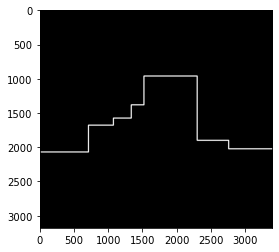

In [36]:
cnts = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
img_contours = np.zeros(imagen.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -0, (255,255,255), 15)
plt.imshow(img_contours)

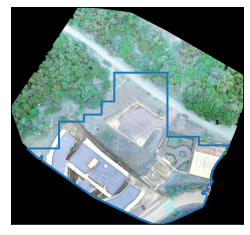

In [37]:
# Find contours at a constant value of 0.8
contours = measure.find_contours(fg[:,:,1], 0.8)
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(imagen, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [38]:
print(len(contours))

34


In [39]:
poligono = []
for cnt in contours : 
    poligono1 = []
    for ind in cnt:
        #print(ind)
        x1,y1 = dataset.xy(ind[0], ind[1])
        poligono1.append([x1,y1,0.0])
    poligono.append([poligono1])

In [40]:
fn = 'Poligonos/new.shp'
opts = {
    'driver': 'ESRI Shapefile',
    'schema': {'geometry': '3D MultiPolygon', 'properties': {}},
    'crs' : dataset.crs
}
with fiona.open(fn, mode='w', **opts) as c:
    c.write({'geometry': {'type': 'MultiPolygon', 'coordinates': poligono}, 'properties': {}})